In [1]:
from __future__ import division
from math import log, exp, tan, atan, pi, ceil
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import time
import scipy.spatial as spatial
from mayavi import mlab
# mlab.init_notebook()
import glob
from termcolor import colored
import re
import scipy.io as sio
from scipy.interpolate import InterpolatedUnivariateSpline
import shdom

import sys


%matplotlib notebook

# Simulate Gecko camera at spectral range 620-670 nm

In [2]:
scene_spectrum=[620,670]

GECKO = {'PIXEL_SIZE':5.5,'FULLWELL':13.5e3,'CHeight': 2048, 'CWidth': 2048 ,
              'SENSOR_ID':0, 'READOUT_NOISE':13, 'DARK_CURRENT_NOISE':125, 'TEMP':25 , 'BitDepth':10}



Now the lens attribute in the imager instance is considered as defined.


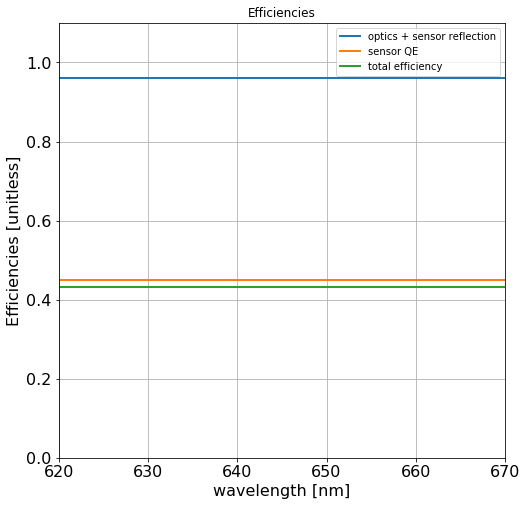

In [3]:
# Define sensor:
sensor = shdom.SensorFPA(PIXEL_SIZE = GECKO['PIXEL_SIZE'],FULLWELL = GECKO['FULLWELL'], CHeight = GECKO['CHeight'], CWidth = GECKO['CWidth'],
    SENSOR_ID = GECKO['SENSOR_ID'],  READOUT_NOISE = GECKO['READOUT_NOISE'], 
    DARK_CURRENT_NOISE = GECKO['DARK_CURRENT_NOISE'], TEMP = GECKO['TEMP'], BitDepth = GECKO['BitDepth'])


SENSOR_DARK_NOISE_CSV_FILE = 'GECKO_DARK_NOISE.csv'
sensor.Load_DARK_NOISE_table(SENSOR_DARK_NOISE_CSV_FILE)


#  The Standard Gecko is a 70mm F4 refractive lens, with typical transmission in the range of 97% (excluding the losses due to spectral filters and the Sensor cover glass)
# Define lens:    
lens = shdom.LensSimple(FOCAL_LENGTH = 70.0 , DIAMETER = 17.5 , LENS_ID = '1') 

# create imager:

imager = shdom.Imager(sensor=sensor,lens=lens,scene_spectrum=scene_spectrum)
imager.assume_sensor_QE(45)
imager.assume_lens_UNITY_TRANSMISSION()
imager.update()
imager.show_efficiencies()

----> Speed in 500[km] orbit is 7.914[km/sec]
Noise and thus SNR (at full well) will change in this step, This what do you want to do?
----> Exposure bound is 4964.144[micro sec]
----> You set exposure time to 4963.144[micro sec]
----> Dynamic range (at full well) changed to 1009.279 or 60.08[db]
----> Noise floor changed to 13.376[electrons]
----> SNR (at full well) changed to 115.284 or 41.303[db]
The exposure time is set here to be the maximum exposure time. The maximum exposure time is calculated to avoide pixel blaring due to motion.
At nadir:
 Pixel footprint is 0.039[km]
 Camera footprint is 80.457[km]
 Max esposure time 4964.144[micro sec]


Report all at maximun exposure time:
----> Diameter is 17.5[mm]
----> SNR is 115.284 or 41.235[db]
----> Full_well is 13500.0[electrons]


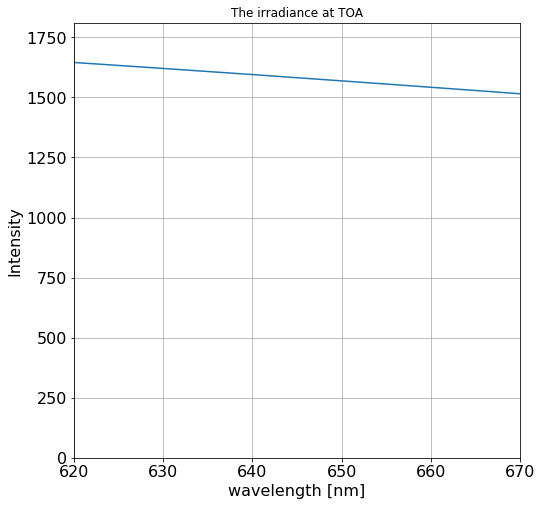

In [4]:
# set geometry:
H = 500 # km
imager.set_Imager_altitude(H=H)
# calclate footprints:
pixel_footprint, camera_footprint = imager.get_footprints_at_nadir()
max_esposure_time = imager.max_exposure_time
pixel_footprint = shdom.float_round(pixel_footprint)
camera_footprint = shdom.float_round(camera_footprint)
max_esposure_time = shdom.float_round(max_esposure_time)
print("At nadir:\n Pixel footprint is {}[km]\n Camera footprint is {}[km]\n Max esposure time {}[micro sec]\n"
      .format(pixel_footprint, camera_footprint, max_esposure_time))    

imager.calculate_scene_radiance(TYPE='SHDOM')
imager.show_scene_irradiance()
imager.ExportConfig(file_name = 'Gecko_config.json')



# simulate dark noise table for Gecko

Dark current 125e/s at 25 C. Noise doubles every 7-8deg C. Read Noise is 13 e RMS

,noise [electrons/sec],temp
0,3,-10
1,7,-3
2,15,4
3,31,11
4,62,18
5,125,25
6,250,32
7,500,39
8,1000,46
9,2000,53


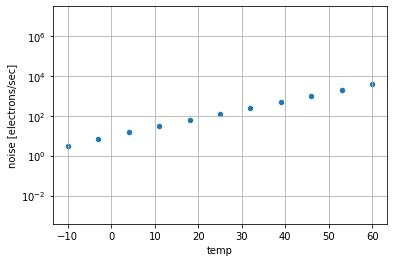

In [5]:
csv_file_name = 'GECKO_DARK_NOISE.csv'

samples = []
sample_base = [125, 25] # [0] is the noise in [electrocs/sec] at temp of [1]
dx = 7
samples_p = [sample_base]
#go in +
for temp in range(5):
#     print(temp)
    dy = 1*samples_p[-1][0]
    samples_p.append([samples_p[-1][0]+dy,dx+samples_p[-1][1]])

samples_m = [sample_base]
#go in -
for temp in range(5):
#     print(temp)
    dy = (1/2)*samples_m[-1][0]
    samples_m.append([samples_m[-1][0]-dy,-dx+samples_m[-1][1]])

a = np.array(samples_m[::-1][:-1])
b = np.array(samples_p)
c = np.vstack((a,b))
data = [[int(x),int(y)] for x,y in c]
df = pd.DataFrame(data=data,columns=['noise [electrons/sec]','temp'],index=None)
df.plot(kind='scatter', x='temp', y='noise [electrons/sec]', grid=True,logy =True)
df.to_csv(csv_file_name,index=False) # use index=False to avoide indexindg od raws.
df

In [ ]:
# set required radiance that should reach the lens, what should be the diameter of the lens
# such that the pixel will reache its full well:
imager.calculate_scene_radiance(rho=0.052)
imager.update_minimum_lens_diameter()


# Simulate Hyperion camera at spectral range 620-670 nm

The IM200 is a modified version of the Hyperion ST200 Star Tracker, which has flown on over 13 missions since 2015.
The IM200 itself has not flown yet.
Footprints:Considering that the company offers optics with 16 mm F1.2 or 50 mm F2.0 lens, the resolution is 2048x1944
pixels and pixel pitch is 2 um (2 um provided by the company, we must insure that number). 
   
    
4 Megapixel RGB matrix  2048x1944
I assume QE >55%

In [7]:
IM200 = {'PIXEL_SIZE':2,'FULLWELL':None,'CHeight': 2048, 'CWidth': 1944 ,
              'SENSOR_ID':4, 'READOUT_NOISE':5, 'DARK_CURRENT_NOISE':35, 'BitDepth':8}
    
    
    
    
# Define sensor:
sensor = shdom.SensorFPA(PIXEL_SIZE = IM200['PIXEL_SIZE'],FULLWELL = IM200['FULLWELL'], CHeight = IM200['CHeight'], CWidth = IM200['CWidth'],
    SENSOR_ID = IM200['SENSOR_ID'],  READOUT_NOISE = IM200['READOUT_NOISE'], 
    DARK_CURRENT_NOISE = IM200['DARK_CURRENT_NOISE'], BitDepth = IM200['BitDepth'])

# Define lens:    
lens = shdom.LensSimple(FOCAL_LENGTH = 50.0 , DIAMETER = 25.0 , LENS_ID = '4') 

# create imager:
scene_spectrum=[620,670]

imager = shdom.Imager(sensor=sensor,lens=lens,scene_spectrum=scene_spectrum,temp=20)
imager.assume_sensor_QE(45)
imager.assume_lens_UNITY_TRANSMISSION()
imager.update()
imager.show_efficiencies()
    

TypeError: 'NoneType' object is not subscriptable

In [5]:
# set geometry:
H = 500 # km
imager.set_Imager_altitude(H=H)
pixel_footprint, camera_footprint = imager.get_footprints_at_nadir()
max_esposure_time = imager.max_esposure_time
pixel_footprint = shdom.float_round(pixel_footprint)
camera_footprint = shdom.float_round(camera_footprint)
max_esposure_time = shdom.float_round(max_esposure_time)
print("At nadir:\n Pixel footprint is {}[km]\n Camera footprint is {}\n[km]\n Max esposure time {}[micro sec]\n"
      .format(pixel_footprint, camera_footprint, max_esposure_time))    

imager.calculate_scene_radiance(TYPE='SHDOM')
imager.show_scene_irradiance()

NameError: name 'imager' is not defined

# Simulate Raptor's Owl 1280 VIS-SWIR Digital camera at spectral range 1628-1652 nm (as in MODIS)

opposed to VIS cameras, in the SWIR case we don't have any information about the lens, so we will assume it here.
We will require certain footprint on the graond at nadir view and than calculate the focal length. Than we will requaire minimal radiance that reach the lens, then calculate the diameter of the lens that will create gathering of ligth such that a pixel reaches its full well with the maximum expusure time. 

Remember to set sensor QE and lens TRANSMISSION!
Now the lens attribute in the imager instance is considered as defined.


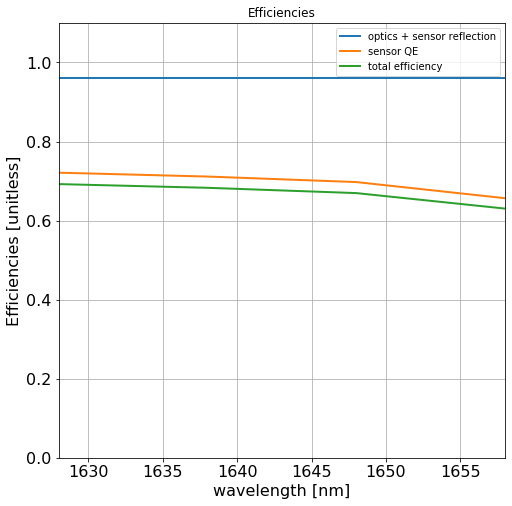

In [6]:
SWIR = {'PIXEL_SIZE':10,'FULLWELL':500e3,'CHeight': 1280 , 'CWidth': 1024 ,
        'SENSOR_ID':3, 'READOUT_NOISE':160, 'DARK_CURRENT_NOISE':19e3,'TEMP':15,
        'BitDepth':14,'TYPE':'SWIR'}
    
 
# Define sensor:
sensor = shdom.SensorFPA(PIXEL_SIZE = SWIR['PIXEL_SIZE'],FULLWELL = SWIR['FULLWELL'], 
                         CHeight = SWIR['CHeight'], CWidth = SWIR['CWidth'],
                         SENSOR_ID = SWIR['SENSOR_ID'],  READOUT_NOISE = SWIR['READOUT_NOISE'], 
                         DARK_CURRENT_NOISE = SWIR['DARK_CURRENT_NOISE'],TEMP = SWIR['TEMP'], BitDepth = SWIR['BitDepth']
                         ,TYPE=SWIR['TYPE'])


SENSOR_QE_CSV_FILE = 'allide_swir.csv'
SENSOR_DARK_NOISE_CSV_FILE = 'SWIR_DARK_NOISE.csv'

sensor.Load_QE_table(SENSOR_QE_CSV_FILE)
sensor.Load_DARK_NOISE_table(SENSOR_DARK_NOISE_CSV_FILE)

# ---------------------------------------------------------------------------------

# create imager:
scene_spectrum=[1628, 1658]

imager = shdom.Imager(sensor=sensor,scene_spectrum=scene_spectrum)
imager.assume_lens_UNITY_TRANSMISSION()
imager.update()
imager.show_efficiencies()    

----> Speed in 500[km] orbit is 7.914[km/sec]
Noise and thus SNR (at full well) will change in this step, This what do you want to do?
----> Exposure bound is 8845.201[micro sec]
----> You set exposure time to 8844.201[micro sec]
----> Dynamic range (at full well) changed to 1103.375 or 60.854[db]
----> Noise floor changed to 453.155[electrons]
----> SNR (at full well) changed to 689.327 or 56.99[db]
The exposure time is set here to be the maximum exposure time. The maximum exposure time is calculated to avoide pixel blaring due to motion.
Diffreaction limit is met, The spot size is 20.0 [micro m]
The focal length will change in this step, This what do you want to do?
----> Focal length is set to 100.0[mm]
To be outside the diffreaction limit, the lens diameter should be larger than 20.228 mm
----> Exposure bound is set to 6318.001[micro sec]
----> Dynamic range (at full well) bound is set to 1353.472 or 62.629[db]
----> Noise floor bound is set to 369.42[electrons]
----> SNR (at full 

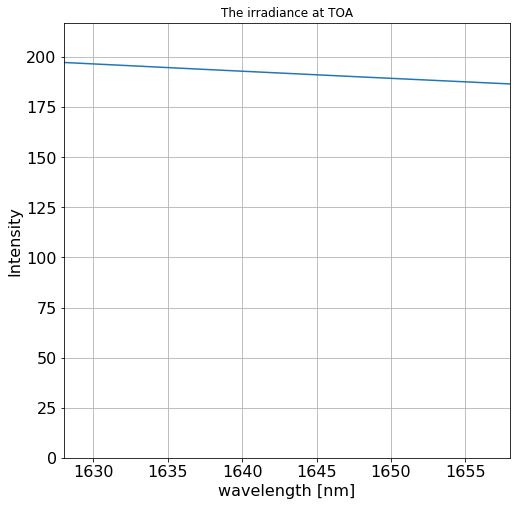

In [10]:
# set geometry:
H = 500 # km
imager.set_Imager_altitude(H=H)

# set required pixel footprint:
Required_pixel_footprint = 0.05 # km
# what should be the focal length of the lens? set the required pixel footprint, then see the printed Focal lennth it requaires.
imager.set_pixel_footprint(Required_pixel_footprint)

# set required radiance that should reach the lens, what should be the diameter of the lens
# such that the pixel will reache its full well:
imager.calculate_scene_radiance(rho=0.15)
imager.update_minimum_lens_diameter()

# imager.calculate_scene_radiance(TYPE='SHDOM')
imager.show_scene_irradiance()
imager.ExportConfig(file_name = 'Hypothetic_SWIR_camera_config_50m_nadir_resolution.json')


# Ganerate dark noise tables

The dark noise of InGaAs-based sensors approximately triples with every 10C increase.

In the SWIR range we use dark noise of 19e3 at 15C in 10x10 um pixel.

So to ganerate a dark noise table we use the above as a basline


In [8]:
csv_file_name = 'SWIR_DARK_NOISE.csv'

# samples = []
# sample_base = [19e3, 15] # [0] is the noise in [electrocs/sec] at temp of [1]
# samples.append(sample_base)
# samples_genaretad_1 = [3*sample_base[0],10+sample_base[1]] # using the fact: The dark noise of InGaAs-based sensors approximately triples with every 10C increase
# samples.append(samples_genaretad_1)
# samples_genaretad_2 = [3*samples_genaretad_1[0],10+samples_genaretad_1[1]]
# samples.append(samples_genaretad_2)
# samples_genaretad_3 = [3*samples_genaretad_2[0],10+samples_genaretad_2[1]]
# samples.append(samples_genaretad_3)
# samples_genaretad_4 = [3*samples_genaretad_3[0],10+samples_genaretad_3[1]]
# samples.append(samples_genaretad_4)
# samples_genaretad_5 = [3*samples_genaretad_4[0],10+samples_genaretad_4[1]]
# samples.append(samples_genaretad_5)


# df = pd.DataFrame(data=samples,columns=['noise','temp'],index=None)
# df


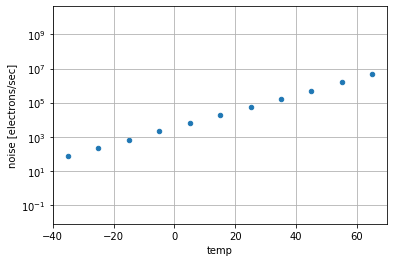

In [9]:
samples = []
sample_base = [19e3, 15] # [0] is the noise in [electrocs/sec] at temp of [1]
dx = 10
samples_p = [sample_base]
#go in +
for temp in range(5):
#     print(temp)
    dy = 2*samples_p[-1][0]
    samples_p.append([samples_p[-1][0]+dy,dx+samples_p[-1][1]])

samples_m = [sample_base]
#go in -
for temp in range(5):
#     print(temp)
    dy = (2/3)*samples_m[-1][0]
    samples_m.append([samples_m[-1][0]-dy,-dx+samples_m[-1][1]])

a = np.array(samples_m[::-1][:-1])
b = np.array(samples_p)
c = np.vstack((a,b))
data = [[int(x),int(y)] for x,y in c]
df = pd.DataFrame(data=data,columns=['noise [electrons/sec]','temp'],index=None)
df.plot(kind='scatter', x='temp', y='noise [electrons/sec]', grid=True,logy =True)
df.to_csv(csv_file_name,index=False) # use index=False to avoide indexindg od raws.

# Test noise in SWIR

In [9]:
# load Imager at SWIR:
swir_imager = shdom.Imager.ImportConfig(file_name = 'Hypothetic_SWIR_camera_config.json')

I = np.zeros([100,100])
In = swir_imager.add_noise(I)

Finish to import imager from Hypothetic_SWIR_camera_config.json.



TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'